In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [46]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 7# For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  =100
    activation        = 'elu'
    classification_act= 'linear'
    model_constraint  =  1
    regularization    = 0.000
    manifold          = 0.00
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 500
    
    num_networks      = 6
    

In [47]:
import tensorflow as tf
from mat4py import loadmat
import numpy as np
import pandas as pd
from Utilities.plotting_sine import plot_sine
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.L2_error_computation import error_L2
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.model_constraint import compute_interior_loss
from Utilities.model_constraint_weak import compute_interior_loss_weak
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [48]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20
    activation        = 'relu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.001
    model_constraint  =  300
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 2000

In [49]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [50]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



ListWrapper([2, 100, 100, 1])
Beginning Training
            Epoch 0            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Model: "final_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  10100     
_________________________________________________________________
W3 (Dense)                   multiple                  10100     
_________________________________________________________________
upsampling_layer (Dense)     multiple                  300       
_________________________________________________________________
classification_layer (Dense) multiple                  101       
Total params: 20,601
Trainable params: 10,201
Non-trainable params: 10,400
_________________________________________________________________
Time per Batch: 0.12
Time per Epoch: 1.2

Time per Epoch: 1.36

Training Set: Loss: 2.206e+01, Accuracy: 18.927
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 3.327

Previous Layer Relative # of 0s: 0.0000000

            Epoch 16            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.11
Time per Epoch: 1.46

Training Set: Loss: 2.127e+01, Accuracy: 18.589
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.114

Previous Layer Relative # of 0s: 0.0000000

            Epoch 17            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.31

Training Set: Loss: 2.150e+01, Accuracy: 18.437
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 3.425

Previous Layer Relative # of 0s: 0.0000000

            Epoch

Time per Epoch: 1.16

Training Set: Loss: 1.874e+01, Accuracy: 15.803
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.068

Previous Layer Relative # of 0s: 0.0000000

            Epoch 35            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.18

Training Set: Loss: 1.900e+01, Accuracy: 15.866
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.877

Previous Layer Relative # of 0s: 0.0000000

            Epoch 36            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.31

Training Set: Loss: 1.857e+01, Accuracy: 15.658
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.445

Previous Layer Relative # of 0s: 0.0000000

            Epoch

Time per Epoch: 1.26

Training Set: Loss: 1.770e+01, Accuracy: 14.412
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.704

Previous Layer Relative # of 0s: 0.0000000

            Epoch 54            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.28

Training Set: Loss: 1.772e+01, Accuracy: 14.414
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.179

Previous Layer Relative # of 0s: 0.0000000

            Epoch 55            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.21

Training Set: Loss: 1.757e+01, Accuracy: 14.352
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.821

Previous Layer Relative # of 0s: 0.0000000

            Epoch

Time per Epoch: 1.29

Training Set: Loss: 1.726e+01, Accuracy: 13.948
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.224

Previous Layer Relative # of 0s: 0.0000000

            Epoch 73            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.29

Training Set: Loss: 1.715e+01, Accuracy: 13.829
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.787

Previous Layer Relative # of 0s: 0.0000000

            Epoch 74            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.20

Training Set: Loss: 1.710e+01, Accuracy: 13.880
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.239

Previous Layer Relative # of 0s: 0.0000000

            Epoch

Time per Epoch: 1.15

Training Set: Loss: 1.682e+01, Accuracy: 13.520
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.592

Previous Layer Relative # of 0s: 0.0000000

            Epoch 92            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.08
Time per Epoch: 1.28

Training Set: Loss: 1.689e+01, Accuracy: 13.557
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.253

Previous Layer Relative # of 0s: 0.0000000

            Epoch 93            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.14

Training Set: Loss: 1.669e+01, Accuracy: 13.459
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.558

Previous Layer Relative # of 0s: 0.0000000

            Epoch

Time per Epoch: 1.19

Training Set: Loss: 1.651e+01, Accuracy: 13.266
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.306

Previous Layer Relative # of 0s: 0.0000000

            Epoch 111            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.22

Training Set: Loss: 1.655e+01, Accuracy: 13.299
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.949

Previous Layer Relative # of 0s: 0.0000000

            Epoch 112            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.23

Training Set: Loss: 1.645e+01, Accuracy: 13.254
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.219

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.21

Training Set: Loss: 1.614e+01, Accuracy: 13.046
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.307

Previous Layer Relative # of 0s: 0.0000000

            Epoch 130            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.15
Time per Epoch: 1.43

Training Set: Loss: 1.583e+01, Accuracy: 12.974
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.543

Previous Layer Relative # of 0s: 0.0000000

            Epoch 131            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.34

Training Set: Loss: 1.618e+01, Accuracy: 12.959
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.908

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.22

Training Set: Loss: 1.578e+01, Accuracy: 12.681
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.219

Previous Layer Relative # of 0s: 0.0000000

            Epoch 149            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.57

Training Set: Loss: 1.580e+01, Accuracy: 12.643
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.747

Previous Layer Relative # of 0s: 0.0000000

            Epoch 150            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.12
Time per Epoch: 1.28

Training Set: Loss: 1.567e+01, Accuracy: 12.637
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.398

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.39

Training Set: Loss: 1.528e+01, Accuracy: 12.266
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.291

Previous Layer Relative # of 0s: 0.0000000

            Epoch 168            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.12
Time per Epoch: 1.44

Training Set: Loss: 1.554e+01, Accuracy: 12.344
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.157

Previous Layer Relative # of 0s: 0.0000000

            Epoch 169            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.18

Training Set: Loss: 1.528e+01, Accuracy: 12.259
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.397

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.51

Training Set: Loss: 1.503e+01, Accuracy: 12.033
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.798

Previous Layer Relative # of 0s: 0.0000000

            Epoch 187            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.15
Time per Epoch: 1.49

Training Set: Loss: 1.516e+01, Accuracy: 12.186
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.496

Previous Layer Relative # of 0s: 0.0000000

            Epoch 188            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.15
Time per Epoch: 1.35

Training Set: Loss: 1.500e+01, Accuracy: 12.064
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.807

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.16

Training Set: Loss: 1.495e+01, Accuracy: 11.920
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.864

Previous Layer Relative # of 0s: 0.0000000

            Epoch 206            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.08
Time per Epoch: 1.13

Training Set: Loss: 1.511e+01, Accuracy: 12.082
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.052

Previous Layer Relative # of 0s: 0.0000000

            Epoch 207            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.08
Time per Epoch: 1.22

Training Set: Loss: 1.459e+01, Accuracy: 11.882
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.030

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.25

Training Set: Loss: 1.481e+01, Accuracy: 11.647
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.292

Previous Layer Relative # of 0s: 0.0000000

            Epoch 225            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.31

Training Set: Loss: 1.491e+01, Accuracy: 11.718
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 3.154

Previous Layer Relative # of 0s: 0.0000000

            Epoch 226            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.23

Training Set: Loss: 1.465e+01, Accuracy: 11.653
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.315

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.49

Training Set: Loss: 1.463e+01, Accuracy: 11.591
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.254

Previous Layer Relative # of 0s: 0.0000000

            Epoch 244            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.14
Time per Epoch: 1.48

Training Set: Loss: 1.477e+01, Accuracy: 11.629
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.249

Previous Layer Relative # of 0s: 0.0000000

            Epoch 245            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.11
Time per Epoch: 1.29

Training Set: Loss: 1.467e+01, Accuracy: 11.581
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.807

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.46

Training Set: Loss: 1.462e+01, Accuracy: 11.600
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.471

Previous Layer Relative # of 0s: 0.0000000

            Epoch 263            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.33

Training Set: Loss: 1.464e+01, Accuracy: 11.538
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.610

Previous Layer Relative # of 0s: 0.0000000

            Epoch 264            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.21

Training Set: Loss: 1.448e+01, Accuracy: 11.497
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.495

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.66

Training Set: Loss: 1.446e+01, Accuracy: 11.471
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.731

Previous Layer Relative # of 0s: 0.0000000

            Epoch 282            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.59

Training Set: Loss: 1.445e+01, Accuracy: 11.414
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.646

Previous Layer Relative # of 0s: 0.0000000

            Epoch 283            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.15
Time per Epoch: 1.55

Training Set: Loss: 1.441e+01, Accuracy: 11.461
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.822

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.29

Training Set: Loss: 1.429e+01, Accuracy: 11.321
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.660

Previous Layer Relative # of 0s: 0.0000000

            Epoch 301            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.34

Training Set: Loss: 1.420e+01, Accuracy: 11.258
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.372

Previous Layer Relative # of 0s: 0.0000000

            Epoch 302            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.12
Time per Epoch: 1.38

Training Set: Loss: 1.416e+01, Accuracy: 11.324
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.457

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.24

Training Set: Loss: 1.403e+01, Accuracy: 11.191
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.256

Previous Layer Relative # of 0s: 0.0000000

            Epoch 320            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.16

Training Set: Loss: 1.418e+01, Accuracy: 11.229
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.512

Previous Layer Relative # of 0s: 0.0000000

            Epoch 321            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.26

Training Set: Loss: 1.418e+01, Accuracy: 11.189
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.634

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.31

Training Set: Loss: 1.405e+01, Accuracy: 11.161
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.679

Previous Layer Relative # of 0s: 0.0000000

            Epoch 339            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.27

Training Set: Loss: 1.389e+01, Accuracy: 11.122
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.538

Previous Layer Relative # of 0s: 0.0000000

            Epoch 340            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.19

Training Set: Loss: 1.400e+01, Accuracy: 11.185
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.762

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.15

Training Set: Loss: 1.401e+01, Accuracy: 11.007
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.455

Previous Layer Relative # of 0s: 0.0000000

            Epoch 358            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.17

Training Set: Loss: 1.373e+01, Accuracy: 10.935
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.719

Previous Layer Relative # of 0s: 0.0000000

            Epoch 359            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.15

Training Set: Loss: 1.400e+01, Accuracy: 11.053
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.474

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.25

Training Set: Loss: 1.376e+01, Accuracy: 10.850
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.432

Previous Layer Relative # of 0s: 0.0000000

            Epoch 377            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.27

Training Set: Loss: 1.374e+01, Accuracy: 10.846
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.393

Previous Layer Relative # of 0s: 0.0000000

            Epoch 378            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.41

Training Set: Loss: 1.378e+01, Accuracy: 10.901
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.413

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.29

Training Set: Loss: 1.378e+01, Accuracy: 10.774
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.923

Previous Layer Relative # of 0s: 0.0000000

            Epoch 396            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.23

Training Set: Loss: 1.362e+01, Accuracy: 10.794
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.052

Previous Layer Relative # of 0s: 0.0000000

            Epoch 397            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.10
Time per Epoch: 1.25

Training Set: Loss: 1.360e+01, Accuracy: 10.841
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.829

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.16

Training Set: Loss: 1.361e+01, Accuracy: 10.694
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.067

Previous Layer Relative # of 0s: 0.0000000

            Epoch 415            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.27

Training Set: Loss: 1.359e+01, Accuracy: 10.609
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.655

Previous Layer Relative # of 0s: 0.0000000

            Epoch 416            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.16

Training Set: Loss: 1.372e+01, Accuracy: 10.703
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.188

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.33

Training Set: Loss: 1.348e+01, Accuracy: 10.588
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.385

Previous Layer Relative # of 0s: 0.0000000

            Epoch 434            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.20

Training Set: Loss: 1.349e+01, Accuracy: 10.486
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.197

Previous Layer Relative # of 0s: 0.0000000

            Epoch 435            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.33

Training Set: Loss: 1.333e+01, Accuracy: 10.429
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.517

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.16

Training Set: Loss: 1.331e+01, Accuracy: 10.477
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.031

Previous Layer Relative # of 0s: 0.0000000

            Epoch 453            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.28

Training Set: Loss: 1.332e+01, Accuracy: 10.405
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.573

Previous Layer Relative # of 0s: 0.0000000

            Epoch 454            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.18

Training Set: Loss: 1.321e+01, Accuracy: 10.393
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.248

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.27

Training Set: Loss: 1.324e+01, Accuracy: 10.374
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.026

Previous Layer Relative # of 0s: 0.0000000

            Epoch 472            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.29

Training Set: Loss: 1.319e+01, Accuracy: 10.359
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.943

Previous Layer Relative # of 0s: 0.0000000

            Epoch 473            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.28

Training Set: Loss: 1.311e+01, Accuracy: 10.387
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.868

Previous Layer Relative # of 0s: 0.0000000

            Epo

Time per Epoch: 1.29

Training Set: Loss: 1.309e+01, Accuracy: 10.300
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 2.050

Previous Layer Relative # of 0s: 0.0000000

            Epoch 491            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.09
Time per Epoch: 1.37

Training Set: Loss: 1.312e+01, Accuracy: 10.355
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.767

Previous Layer Relative # of 0s: 0.0000000

            Epoch 492            
Abalone_FC_L1_mhl7_hl100_rpt0_nTOL4_eTOL4_b500_e500
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 10 batches of size 500:
Time per Batch: 0.12
Time per Epoch: 1.33

Training Set: Loss: 1.317e+01, Accuracy: 10.363
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 1.834

Previous Layer Relative # of 0s: 0.0000000

            Epo

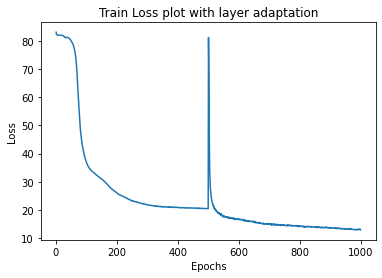

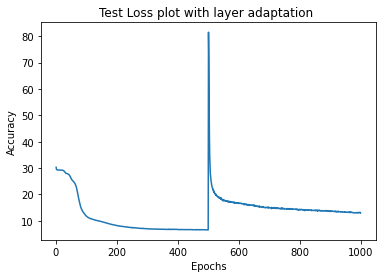

In [51]:
if __name__ == "__main__":     

    trainable=3
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions, data_train_inside, labels_train_inside\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
    gauss_solution=np.loadtxt("gauss_solution.data")
    gauss_solution = tf.cast(gauss_solution,tf.float32)
    

    
    gauss_points = loadmat('gauss_points.mat')
    gauss_points=np.array(list(gauss_points.values()))[-1]
    gauss_points = tf.cast(gauss_points,tf.float32)
    
    gauss_points_new = loadmat('gauss_points_new.mat')
    gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
    gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    
    gauss_weights = loadmat('gauss_weights.mat')
    gauss_weights=np.array(list(gauss_weights.values()))[-1].squeeze(-1)
    
    gauss_weights_new = loadmat('gauss_weights_new.mat')
    gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))
    
    Solution = loadmat('Solution.mat')
    Solution=np.array(list(Solution.values()))[-1]
    Solution=tf.cast(Solution,tf.float32)
    Solution=tf.reshape(Solution,(len(Solution),1))
    
    

    v=[]
    for i in range(0,len(Solution)):
        if np.abs(Solution[i])<1e-10:
            v.append(i)
    
    #for i in range(1,hyperp.num_networks):
    for i in range(1,2):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train,load,Solution=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i,load,Stiffness,Coordinates,Solution)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
            NN._set_inputs( data_train)
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v,data_train_inside, labels_train_inside)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize_step(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v,data_train_inside, labels_train_inside)   
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        
        #plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,2,data_train, labels_train)
        
   
        
        
        
        
        
        
        
        

Text(0, 0.5, 'Accuracy')

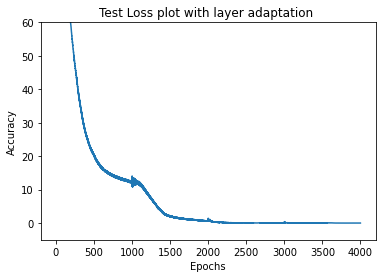

In [22]:
    import matplotlib.pyplot as plt
    
    storage_accuracy_array=[]
    
    no_epoch=hyperp.num_epochs
    
    for i in range(2,trainable):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        
 
        storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
    fig_accuracy = plt.figure()
    x_axis = np.linspace(1, len(storage_accuracy_array), len(storage_accuracy_array), endpoint = True)
    plt.plot(x_axis, storage_accuracy_array)
    plt.ylim(-5, 60)

#plt.title('Accuracy for: ' + run_options.filename)
    plt.title('Test Loss plot with layer adaptation ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')


In [10]:
pred,new = NN(Coordinates)
loss=tf.matmul(Stiffness, pred)
loss_final=tf.math.reduce_sum(tf.keras.losses.MSE(load, loss))

In [12]:
tf.math.reduce_sum(tf.keras.losses.MSE(Solution, pred))

<tf.Tensor: id=6744890, shape=(), dtype=float32, numpy=178.8639>

In [22]:
G=tf.linalg.inv(Stiffness)

KeyboardInterrupt: 

In [92]:
    trainable=2
    
        
    hyperp = Hyperparameters()
    hyperp.max_hidden_layers=8
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions, data_train_inside, labels_train_inside\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed)  
 

In [194]:
data_test

<tf.Tensor: id=5958, shape=(5000, 2), dtype=float32, numpy=
array([[0.38106087, 0.1081669 ],
       [0.4594311 , 0.29319677],
       [0.1487638 , 0.29146183],
       ...,
       [0.79670495, 0.21184906],
       [0.86198735, 0.93216914],
       [0.58006227, 0.56983566]], dtype=float32)>

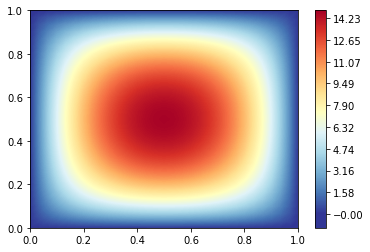

In [9]:
# TRUE SOLUTION

from Utilities.Net import Final_Network
import matplotlib.pyplot as plt

input_plot_data=np.loadtxt("input_plot_data.data")
output_plot_data=np.loadtxt("output_plot_data")


        
x = input_plot_data[:,0]
y = input_plot_data[:,1]

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)


Z=tf.reshape(output_plot_data,np.shape(X))

fig = plt.figure()       

#clevels = np.linspace(0.0019333754, 14.727704, 10000)
levels=np.linspace(-1, 14.8, 1000)
cs=plt.contourf(X, Y, Z,levels, cmap='RdYlBu_r',vmax=14.8, vmin=0.)     
#plt.contourf(X, Y, Z, 1000, cmap='RdYlBu_r', vmax=14.727704, vmin=0.) 
plt.colorbar() 

for c in cs.collections:
    c.set_rasterized(True)


plt.savefig('true_solution_simple.pdf')

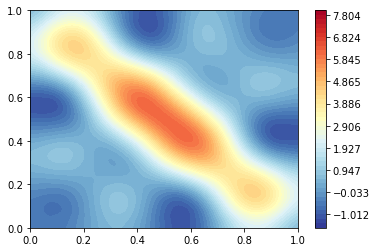

In [93]:
# NEURAL NETWORK SOLUTION

from Utilities.Net import Final_Network
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)

d = []
for i in range(0,1000):
    for j in range(0,1000):
        dd=[X[i,j],Y[i,j]]
        d.append(dd) 

d=np.array(d)
data= tf.cast(d,tf.float32)
Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(17)).expect_partial()
    
y_pred_test_add=Network(data)

        
fig = plt.figure()       
Z=tf.reshape(y_pred_test_add,np.shape(X))
#clevels = np.linspace(0.0019333754, 14.727704, 10000)
levels=np.linspace(-1.6, 8, 50)
cs=plt.contourf(X, Y, Z,levels, cmap='RdYlBu_r',vmax=8, vmin=-1.6)     
#plt.contourf(X, Y, Z, 1000, cmap='RdYlBu_r', vmax=14.727704, vmin=0.) 
plt.colorbar() 

for c in cs.collections:
    c.set_rasterized(True)


plt.savefig('sixth_solution_PRNN.pdf')

In [52]:
Stiffness = loadmat('Stiffness.mat')
Stiffness=np.array(list(Stiffness.values()))[-1]
Stiffness = tf.cast(Stiffness,tf.float32)
    
load = loadmat('observation.mat')
load=np.array(list(load.values()))[-1]
load=tf.cast(load,tf.float32)
load=tf.reshape(load,(len(load),1))
    
Solution = loadmat('Solution.mat')
Solution=np.array(list(Solution.values()))[-1]
Solution=tf.cast(Solution,tf.float32)
Solution=tf.reshape(Solution,(len(Solution),1))

aa=tf.matmul(Stiffness, Solution)

In [25]:
tf.keras.losses.MSE(load, aa)

<tf.Tensor: id=652, shape=(961,), dtype=float32, numpy=
array([7.34591999e-31, 2.71296829e-01, 2.71296829e-01, 1.00600421e+00,
       3.55271368e-15, 1.00600421e+00, 1.91142833e+00, 5.68434189e-14,
       5.68434189e-14, 1.91142833e+00, 2.63079333e+00, 8.88178420e-14,
       8.88178420e-14, 8.88178420e-14, 2.63079333e+00, 2.90322709e+00,
       7.19424520e-14, 5.68434189e-14, 5.68434189e-14, 1.50102153e-13,
       2.90322709e+00, 2.66453648e+00, 3.19744231e-14, 1.42108547e-14,
       1.74082970e-13, 1.27897692e-13, 3.55271368e-15, 2.66453648e+00,
       2.04844165e+00, 8.88178420e-14, 1.27897692e-13, 1.56674673e-12,
       6.00408612e-13, 1.42108547e-14, 3.55271368e-15, 2.04844165e+00,
       1.29939556e+00, 2.68673972e-14, 1.50102153e-13, 6.00408612e-13,
       2.87769808e-13, 6.00408612e-13, 7.46958051e-13, 9.79216708e-14,
       1.29939556e+00, 6.50586665e-01, 9.33142452e-14, 2.22044605e-14,
       5.11590770e-13, 8.88178420e-14, 8.88178420e-14, 5.11590770e-13,
       2.22044605e-14

In [54]:
y_true=tf.reshape(load,(len(load),1))
y_pred=tf.reshape(aa,(len(aa),1))
tf.keras.losses.MSE(y_true, y_pred)

<tf.Tensor: id=11978201, shape=(961,), dtype=float32, numpy=
array([7.34591999e-31, 2.71296829e-01, 2.71296829e-01, 1.00600421e+00,
       3.55271368e-15, 1.00600421e+00, 1.91142833e+00, 5.68434189e-14,
       5.68434189e-14, 1.91142833e+00, 2.63079333e+00, 8.88178420e-14,
       8.88178420e-14, 8.88178420e-14, 2.63079333e+00, 2.90322709e+00,
       7.19424520e-14, 5.68434189e-14, 5.68434189e-14, 1.50102153e-13,
       2.90322709e+00, 2.66453648e+00, 3.19744231e-14, 1.42108547e-14,
       1.74082970e-13, 1.27897692e-13, 3.55271368e-15, 2.66453648e+00,
       2.04844165e+00, 8.88178420e-14, 1.27897692e-13, 1.56674673e-12,
       6.00408612e-13, 1.42108547e-14, 3.55271368e-15, 2.04844165e+00,
       1.29939556e+00, 2.68673972e-14, 1.50102153e-13, 6.00408612e-13,
       2.87769808e-13, 6.00408612e-13, 7.46958051e-13, 9.79216708e-14,
       1.29939556e+00, 6.50586665e-01, 9.33142452e-14, 2.22044605e-14,
       5.11590770e-13, 8.88178420e-14, 8.88178420e-14, 5.11590770e-13,
       2.2204460

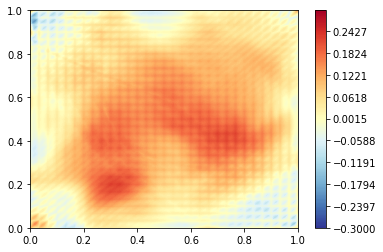

In [80]:
# NEURAL NETWORK SOLUTION

from Utilities.Net import Final_Network
import matplotlib.pyplot as plt


i_val=2


x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)

d = []
for i in range(0,1000):
    for j in range(0,1000):
        dd=[X[i,j],Y[i,j]]
        d.append(dd) 

d=np.array(d)
data= tf.cast(d,tf.float32)


i_val=i_val+1
    
    
if i_val>1:
    for i_net in range(2,i_val+1):
                
        if i_net==2:    
            Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(i_net-1)).expect_partial()
    
            y_pred_test_add=Network(data)
        
        if i_net>2:
                
            Network=Final_Network_ALGO_II( hyperp_new,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(i_net-1)).expect_partial()
    
            y_pred_test_add=y_pred_test_add+Network(data)
        


     
fig = plt.figure()       
Z=tf.reshape((output_plot_data-y_pred_test_add[:,0]),np.shape(X))
#clevels = np.linspace(0.0019333754, 14.727704, 10000)
levels=np.linspace(-0.3, 0.3, 200)
cs=plt.contourf(X, Y, Z,levels, cmap='RdYlBu_r',vmax=0.3, vmin=-0.3)     
#plt.contourf(X, Y, Z, 1000, cmap='RdYlBu_r', vmax=14.727704, vmin=0.) 
plt.colorbar() 

for c in cs.collections:
    c.set_rasterized(True)


plt.savefig('error_one_simple.pdf')




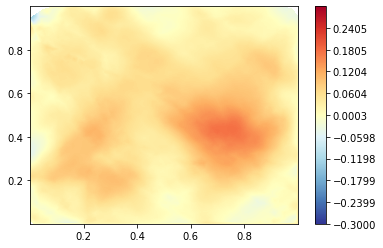

In [105]:
# PLOT ERROR MAP

from Utilities.Net import Final_Network
import matplotlib.pyplot as plt


i_val=7



data= data_test


i_val=i_val+1
    
    
if i_val>1:
    for i_net in range(2,i_val+1):
                
        if i_net==2:    
            Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(i_net-1)).expect_partial()
    
            y_pred_test_add=Network(data)
        
        if i_net>2:
                
            Network=Final_Network_ALGO_II( hyperp_new,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(i_net-1)).expect_partial()
    
            y_pred_test_add=y_pred_test_add+Network(data)
        

x = data_test[:,0]
y = data_test[:,1]
     
     
fig = plt.figure()   
#clevels = np.linspace(0.0019333754, 14.727704, 10000)
levels=np.linspace(-0.3, 0.3, 1000)
cs = plt.tricontourf(x, y, labels_test-y_pred_test_add[:,0], levels, cmap='RdYlBu_r', vmax=0.3, vmin=-0.3)
plt.colorbar(cs)


for c in cs.collections:
    c.set_rasterized(True)


plt.savefig('error_six_simple.pdf')

